In [ ]:
!pip install pycaret

In [ ]:
import pandas as pd
df = pd.read_csv("/content/creditcard.csv")              # Uploading on Colab

data = df.sample(frac=0.1, random_state=42)               # Sample 10% of the original data to reduce training time 
data.reset_index(drop=True, inplace=True)
print('Smaller Dataset:', data.shape)

Smaller Dataset: (28481, 31)


In [ ]:
data_unseen = data.sample(frac=0.1, random_state=42)      # Sample 10% of the data to become the unseen test set
data = data.drop(data_unseen.index)                      # Use the remaining 90% as the training (& validation) data

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Model Training & Validation: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

data_unseen.to_csv('/content/test.csv')

Data for Model Training & Validation: (23070, 31)
Unseen Data For Predictions: (2563, 31)


In [ ]:
from pycaret.classification import *

In [ ]:
import mlflow
mlflow.set_tracking_uri('file:/content/mlruns')

In [ ]:
expt = setup(
    data = data, 
    target = 'Class', 
    session_id=42,                      # Random seed to ensure reproducibility of the experiment with the same data
    train_size=0.8,                     # 80% training data & 20% held-out validation data 
    normalize=True,
    normalize_method="minmax",
    polynomial_features=True,
    trigonometry_features=True,
    fix_imbalance=True,
    log_experiment=True,
    experiment_name='Credit Card Fraud - Expt 2',
    log_plots=True 
)

,Description,Value
0,session_id,42
1,Target,Class
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(23070, 31)"
5,Missing Values,False
6,Numeric Features,30
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
top2 = compare_models(sort='F1', fold=5, n_select=2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9992,0.9435,0.7048,0.8057,0.7347,0.7343,0.7444,2.020
rf,Random Forest Classifier,0.9990,0.9598,0.6381,0.7581,0.6805,0.6800,0.6886,11.986
gbc,Gradient Boosting Classifier,0.9984,0.9576,0.6714,0.5317,0.5874,0.5866,0.5937,54.442
ada,Ada Boost Classifier,0.9984,0.9371,0.6714,0.5445,0.5757,0.5750,0.5907,10.650
lightgbm,Light Gradient Boosting Machine,0.9985,0.9293,0.5762,0.6465,0.5733,0.5726,0.5912,1.904
knn,K Neighbors Classifier,0.9966,0.8369,0.6762,0.2801,0.3942,0.3928,0.4326,10.200
dt,Decision Tree Classifier,0.9974,0.7230,0.4476,0.3044,0.3561,0.3548,0.3646,1.910
svm,SVM - Linear Kernel,0.9873,0.0000,0.7381,0.1232,0.2007,0.1984,0.2840,0.214
lr,Logistic Regression,0.9862,0.9594,0.7381,0.0929,0.1613,0.1588,0.2531,2.152
ridge,Ridge Classifier,0.9829,0.0000,0.7714,0.0753,0.1358,0.1332,0.2344,0.108


In [16]:
et = top2[0]

et_params = {
    'min_samples_split': np.arange(1, 25, 1),
    'max_depth': [int(x) for x in np.linspace(10, 160, num = 11)],
    'max_features': ["auto", "sqrt", "log2"],
}

tuned_et = tune_model(et, optimize='F1', custom_grid=et_params, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9997,0.9910,0.8571,1.0000,0.9231,0.9229,0.9257
1,0.9992,0.9020,0.8333,0.7143,0.7692,0.7688,0.7711
2,0.9992,0.9044,0.5000,1.0000,0.6667,0.6663,0.7068
3,0.9992,0.9997,0.8333,0.7143,0.7692,0.7688,0.7711
4,0.9989,0.9745,0.6667,0.6667,0.6667,0.6661,0.6661
Mean,0.9992,0.9543,0.7381,0.8190,0.7590,0.7586,0.7682
SD,0.0003,0.0425,0.1372,0.1488,0.0940,0.0941,0.0883


In [17]:
rf = top2[1]

rf_params = {
    'min_samples_split': np.arange(5, 10, 1),
    'max_depth': [int(x) for x in np.linspace(20, 110, num = 11)],
    'max_features': ["auto", "sqrt", "log2"],
}

tuned_rf = tune_model(rf, optimize='F1', custom_grid=rf_params, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9997,0.9959,0.8571,1.0000,0.9231,0.9229,0.9257
1,0.9989,0.9882,0.6667,0.6667,0.6667,0.6661,0.6661
2,0.9992,0.9075,0.5000,1.0000,0.6667,0.6663,0.7068
3,0.9989,0.9997,0.6667,0.6667,0.6667,0.6661,0.6661
4,0.9986,0.9922,0.5000,0.6000,0.5455,0.5448,0.5471
Mean,0.9991,0.9767,0.6381,0.7867,0.6937,0.6933,0.7024
SD,0.0004,0.0348,0.1325,0.1759,0.1239,0.1241,0.1238


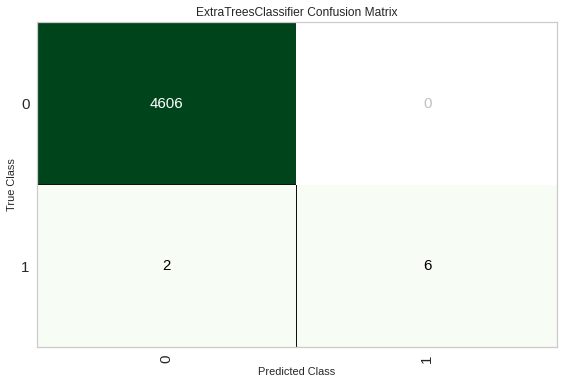

In [18]:
plot_model(tuned_et, plot="confusion_matrix")

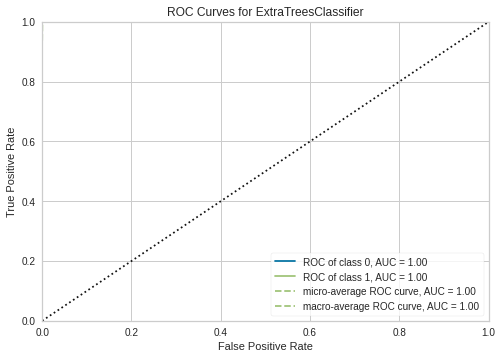

In [19]:
plot_model(tuned_et, plot="auc")

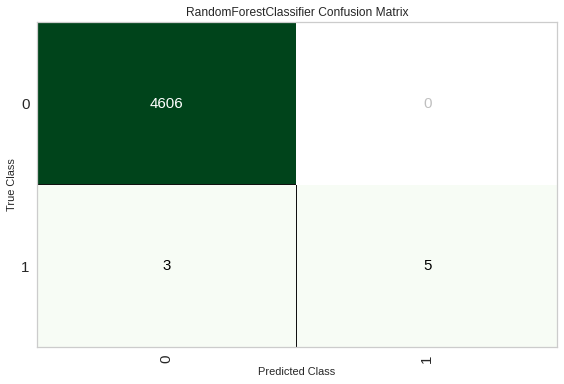

In [20]:
plot_model(tuned_rf, plot="confusion_matrix")

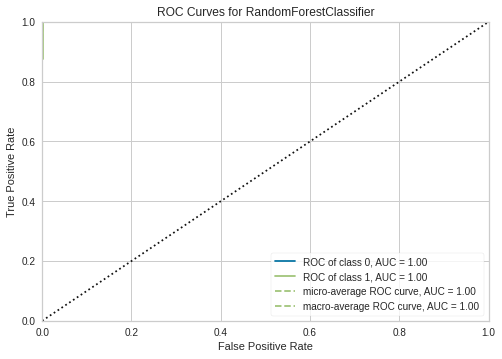

In [21]:
plot_model(tuned_rf, plot="auc")

In [26]:
predict_model(tuned_et);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9996,0.9999,0.75,1.0,0.8571,0.8569,0.8658


In [27]:
predict_model(tuned_rf);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9993,0.9999,0.625,1.0,0.7692,0.7689,0.7903


In [28]:
final_et = finalize_model(tuned_et)

In [29]:
final_rf = finalize_model(tuned_rf)

In [32]:
!pip install boto3

In [36]:
import os

os.environ['AWS_DEFAULT_REGION'] = 'ap-south-1'
os.environ['AWS_ACCESS_KEY_ID'] = ###                       # Value replaced after deploying model
os.environ['AWS_SECRET_ACCESS_KEY'] = ###                   # Value replaced after deploying model

In [37]:
deploy_model(model=final_et, model_name='et_deployed', platform='aws', authentication={'bucket': 'mlopsassignment180100112'})

Model Successfully Deployed on AWS S3


In [38]:
deploy_model(model=final_rf, model_name='rf_deployed', platform='aws', authentication={'bucket': 'mlopsassignment180100112'})

Model Successfully Deployed on AWS S3


In [ ]:
!zip -r /content/mlruns.zip /content/mlruns